In [1]:
import os
import csv
import torch
import argparse
import numpy as np
from tqdm import tqdm
from torch import nn, optim
from GameFormer.predictor import GameFormer
from torch.utils.data import DataLoader
from GameFormer.train_utils import *
from common_utils import *
from GameFormer.data_utils import *
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping

data_path = 'nuplan/dataset/data/cache/train_boston'
map_path = 'nuplan/dataset/maps'
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
debug = False
map_version = "nuplan-maps-v1.0"
sensor_root = None
db_files = None

scenario_mapping = ScenarioMapping(scenario_map=get_scenario_map(), subsample_ratio_override=0.5)
builder = NuPlanScenarioBuilder(data_path, map_path, sensor_root, db_files, map_version, scenario_mapping=scenario_mapping)

scenario_filter = ScenarioFilter(*get_filter_parameters(scenarios_per_type, total_scenarios, shuffle_scenarios))
worker = SingleMachineParallelExecutor(use_process_pool=True)
scenarios = builder.get_scenarios(scenario_filter, worker) 

In [2]:
# Arguments
encoder_layers = 3
decoder_levels = 2
num_neighbors = 10
batch_size = 32
device = 'cuda'

In [3]:
# set up model
gameformer = GameFormer(encoder_layers=encoder_layers, decoder_levels=decoder_levels, neighbors=num_neighbors)
gameformer = gameformer.to(device)

In [4]:
idx = 10

scenario = scenarios[idx]
log_name = scenario.log_name
map_name = scenario._map_name
token = scenario.token
print(f"Map name: {map_name}")
print(f"Scenario token: {token}")

Map name: us-ma-boston
Scenario token: 005eca0e9ffb5058


In [5]:
# set up data loaders
# train_set = DrivingData(train_set + '/*.npz', num_neighbors)

train_files = ['nuplan/processed_data/train/train_boston' + f'/{map_name}_{token}.npz']
train_set = DrivingData(train_files, num_neighbors)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

### train_epoch

In [6]:
data_loader = train_loader
model = gameformer.eval()
weight_path = 'training_log/Exp1/model_epoch_19_valADE_2.4578.pth'
checkpoint = torch.load(weight_path)
model.load_state_dict(checkpoint)
model.eval()

# data_epoch: list, len = 7
# data_epoch[0]: tensor, shape = torch.Size([32, 21, 7])

with tqdm(data_loader, desc="Training", unit="batch") as data_epoch:
    for batch in data_epoch:
        # prepare data
        inputs = {
            'ego_agent_past': batch[0].to(device),
            'neighbor_agents_past': batch[1].to(device),
            'map_lanes': batch[2].to(device),
            'map_crosswalks': batch[3].to(device),
            'route_lanes': batch[4].to(device)
        }
          
        ego_future = batch[5].to(device)
        neighbors_future = batch[6].to(device)
        # bool
        neighbors_future_valid = torch.ne(neighbors_future[..., :2], 0)

        # call the mdoel
        level_k_outputs, ego_plan = model(inputs)
        loss, results = level_k_loss(level_k_outputs, ego_future, neighbors_future, neighbors_future_valid)
        prediction = results[:, 1:]
        plan_loss = planning_loss(ego_plan, ego_future)

        break

Training:   0%|          | 0/1 [00:06<?, ?batch/s]


In [7]:
level_k_outputs, ego_plan = gameformer(inputs)
ego_plan[0].shape

torch.Size([80, 3])

In [7]:
def level_k_loss(outputs, ego_future, neighbors_future, neighbors_future_valid):
    loss: torch.tensor = 0 # 初始化一个 PyTorch 张量变量 loss 并将其初始值设置为零

    levels = len(outputs.keys()) // 2   # level_k_outputs: traj + score
    gt_future = torch.cat([ego_future[:, None], neighbors_future], dim=1)

    for k in range(levels):
        trajectories = outputs[f'level_{k}_interactions']
        scores = outputs[f'level_{k}_scores']
        predictions = trajectories[:, 1:] * neighbors_future_valid[:, :, None, :, 0, None]
        plan = trajectories[:, :1]
        trajectories = torch.cat([plan, predictions], dim=1)
        il_loss, future, best_mode = imitation_loss(trajectories, scores, gt_future)
        loss += il_loss 

    return loss, future

loss, results = level_k_loss(level_k_outputs, ego_future, neighbors_future, neighbors_future_valid)

imitation_loss

In [9]:
# il_loss, future, best_mode = imitation_loss(trajectories, scores, gt_future) 

trajectories = level_k_outputs['level_2_interactions']
scores = level_k_outputs['level_2_scores']
predictions = trajectories[:, 1:] * neighbors_future_valid[:, :, None, :, 0, None]
plan = trajectories[:, :1]
trajectories = torch.cat([plan, predictions], dim=1)

gt_future = torch.cat([ego_future[:, None], neighbors_future], dim=1)

In [40]:
gmm, scores, ground_truth = trajectories, scores, gt_future

B, N = gmm.shape[0], gmm.shape[1]
distance = torch.norm(gmm[:, :, :, :, :2] - ground_truth[:, :, None, :, :2], dim=-1)
best_mode = torch.argmin(distance.mean(-1), dim=-1)

mu = gmm[..., :2]
best_mode_mu = mu[torch.arange(B)[:, None, None], torch.arange(N)[None, :, None], best_mode[:, :, None]]
best_mode_mu = best_mode_mu.squeeze(2)
dx = ground_truth[..., 0] - best_mode_mu[..., 0]
dy = ground_truth[..., 1] - best_mode_mu[..., 1]

cov = gmm[..., 2:]
best_mode_cov = cov[torch.arange(B)[:, None, None], torch.arange(N)[None, :, None], best_mode[:, :, None]]
best_mode_cov = best_mode_cov.squeeze(2)
log_std_x = torch.clamp(best_mode_cov[..., 0], -2, 2)
log_std_y = torch.clamp(best_mode_cov[..., 1], -2, 2)
std_x = torch.exp(log_std_x)
std_y = torch.exp(log_std_y)
gmm_loss = log_std_x + log_std_y + 0.5 * (torch.square(dx/std_x) + torch.square(dy/std_y))
print(gmm_loss.shape)
gmm_loss = torch.mean(gmm_loss)

torch.Size([1, 11, 80])


In [38]:
score_loss = F.cross_entropy(scores.permute(0, 2, 1), best_mode, reduction='none')

score_loss = score_loss * torch.ne(ground_truth[:, :, 0, 0], 0)
score_loss = torch.mean(score_loss)

In [43]:
ego_plan

tensor([[[ 8.5044e-01, -4.4188e-01, -4.7920e-01],
         [ 1.8099e+00, -4.9309e-01, -5.3320e-02],
         [ 2.6860e+00, -9.3212e-02,  4.2820e-01],
         [ 3.5593e+00,  3.1929e-01,  4.4131e-01],
         [ 4.5173e+00,  4.4214e-01,  1.2754e-01],
         [ 5.4266e+00,  1.0202e-01, -3.5791e-01],
         [ 6.4003e+00,  1.2253e-01,  2.1052e-02],
         [ 7.3534e+00,  3.2478e-01,  2.0912e-01],
         [ 8.2904e+00,  5.7217e-02, -2.7813e-01],
         [ 9.2612e+00,  9.5740e-02,  3.9663e-02],
         [ 1.0212e+01,  3.0290e-01,  2.1443e-01],
         [ 1.1184e+01,  2.6117e-01, -4.2915e-02],
         [ 1.2024e+01, -2.3028e-01, -5.2944e-01],
         [ 1.2960e+01, -4.8442e-01, -2.6506e-01],
         [ 1.3870e+01, -8.1997e-01, -3.5317e-01],
         [ 1.4809e+01, -1.0600e+00, -2.5041e-01],
         [ 1.5589e+01, -1.6390e+00, -6.3842e-01],
         [ 1.6535e+01, -1.8562e+00, -2.2570e-01],
         [ 1.7472e+01, -1.6082e+00,  2.5876e-01],
         [ 1.8440e+01, -1.6037e+00,  4.6368e-03],


In [8]:
print(level_k_outputs.keys())
#  1 initial decoding layer and 2 interaction decoding layers
traj_0 = level_k_outputs['level_0_interactions']
print(traj_0.shape)   # shape = N * 6 * 80 * 2
traj_1 = level_k_outputs['level_1_interactions']
traj_2 = level_k_outputs['level_2_interactions']

dict_keys(['level_0_interactions', 'level_0_scores', 'level_1_interactions', 'level_1_scores', 'level_2_interactions', 'level_2_scores'])
torch.Size([1, 11, 6, 80, 4])


In [11]:
traj_0[:, 1:][0][0, 0, :, :2].shape

torch.Size([80, 2])

In [89]:
obs_trajs = inputs['ego_agent_past'].cpu().detach().numpy()
nbr_obs_trajs = inputs['neighbor_agents_past'].cpu().detach().numpy()
fut_trajs = ego_future.cpu().detach().numpy()
nbr_fut_trajs = neighbors_future.cpu().detach().numpy()
pred_trajs = prediction.cpu().detach().numpy()
plan_trajs = ego_plan.cpu().detach().numpy()
neighbors_future_vals = neighbors_future_valid.cpu().detach().numpy()
print("obs_traj.shape: ", obs_trajs.shape)
print("fut_traj.shape: ", fut_trajs.shape)
print("neighbors_obs.shape: ", nbr_obs_trajs.shape)
print("neighbors_future.shape: ", nbr_fut_trajs.shape)
print("neighbors_future_val.shape: ", neighbors_future_vals.shape)
print("pred_traj.shape: ", pred_trajs.shape)
print("plan_traj.shape: ", plan_trajs.shape)
print('--------------------------------------------------')
map_lanes = inputs['map_lanes'].cpu().detach().numpy()
map_crosswalks = inputs['map_crosswalks'].cpu().detach().numpy()
route_lanes = inputs['route_lanes'].cpu().detach().numpy()
print("map_lanes.shape: ", map_lanes.shape)
print("map_crosswalks.shape: ", map_crosswalks.shape)
print("route_lanes.shape: ", route_lanes.shape)


obs_traj.shape:  (1, 21, 7)
fut_traj.shape:  (1, 80, 3)
neighbors_obs.shape:  (1, 20, 21, 11)
neighbors_future.shape:  (1, 10, 80, 3)
neighbors_future_val.shape:  (1, 10, 80, 2)
pred_traj.shape:  (1, 10, 80, 2)
plan_traj.shape:  (1, 80, 3)
--------------------------------------------------
map_lanes.shape:  (1, 40, 50, 7)
map_crosswalks.shape:  (1, 5, 30, 3)
route_lanes.shape:  (1, 10, 50, 3)


In [90]:
scenario.initial_ego_state.rear_axle.as_matrix()

array([[-9.99959843e-01, -8.96172373e-03,  3.32859639e+05],
       [ 8.96172373e-03, -9.99959843e-01,  4.68996461e+06],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [91]:
def convert_relative_to_absolute_path(origin_state, relative_traj):
    """
    根据原点状态将相对轨迹转换为绝对轨迹。
    :param origin_state: StateSE2对象，表示原点状态。
    :param relative_traj: 相对轨迹的NumPy数组，形状为[N, 2]。
    :return: 绝对轨迹的NumPy数组，形状为[N, 2]。
    """
    # 计算旋转矩阵
    heading = origin_state.heading
    cos_theta = np.cos(heading)
    sin_theta = np.sin(heading)
    rotation_matrix = np.array([[cos_theta, sin_theta], [-sin_theta, cos_theta]])
    
    # 应用旋转和平移
    absolute_traj = np.dot(relative_traj, rotation_matrix) + np.array([origin_state.x, origin_state.y])
    
    return absolute_traj


def convert_trajs_to_absolute_array(origin_state, traj_list):
    """
    将一系列轨迹从相对坐标转换为绝对坐标，并返回一个 NumPy 数组。
    :param origin_state: 原点状态，即转换的基准点。
    :param traj_list: 轨迹列表，每个轨迹是一个形状为 [N, 2] 的 numpy 数组。
    :return: 转换后的轨迹 NumPy 数组。
    """
    # 使用列表推导式进行转换，并直接将结果转换为 NumPy 数组
    return np.array([convert_relative_to_absolute_path(origin_state, traj[:, :2]) for traj in traj_list])

def convert_map_to_absolute_array(origin_state, map_data):
    """
    将地图数据从相对坐标转换为绝对坐标，并返回一个 NumPy 数组。
    :param origin_state: 原点状态，即转换的基准点。
    :param map_data: 地图数据，形状为 [50, 40, 2] 的 numpy 数组。
    :return: 转换后的地图数据 NumPy 数组。
    """
    # 初始化转换后的地图数组
    absolute_map_data = np.zeros_like(map_data)
    
    # 遍历每个轨迹（或地图特征）
    for i in range(map_data.shape[0]):
        for j in range(map_data.shape[1]):
            # 提取每个点的相对坐标
            relative_point = map_data[i, j, :]
            # 将相对坐标转换为绝对坐标
            absolute_point = convert_relative_to_absolute_path(origin_state, relative_point[np.newaxis, :])
            # 更新转换后的地图数据
            absolute_map_data[i, j, :] = absolute_point
    
    return absolute_map_data


origin_state = scenario.initial_ego_state.rear_axle

nbr number 10


(332643.340625, 332992.659375, 4689950.95, 4689974.050000003)

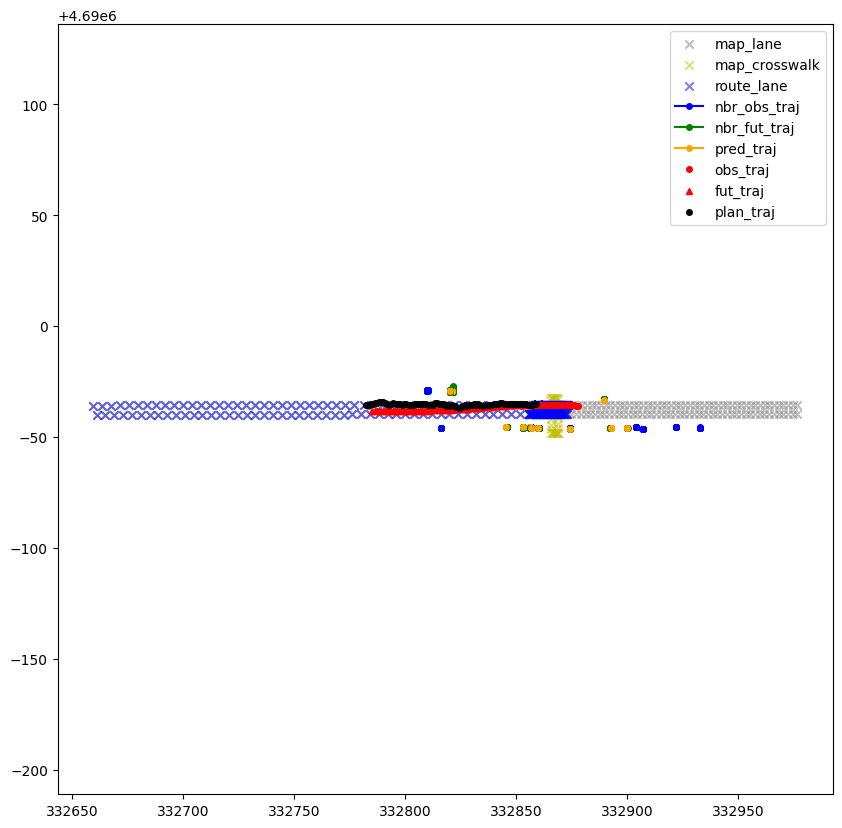

In [92]:
import matplotlib.pyplot as plt

batch_idx = 0
# obs_traj = obs_trajs[batch_idx]
# fut_traj = fut_trajs[batch_idx]
# nbr_obs_traj = nbr_obs_trajs[batch_idx]
# nbr_fut_traj = nbr_fut_trajs[batch_idx]
# pred_traj = pred_trajs[batch_idx]
# plan_traj = plan_trajs[batch_idx]
# map_lane = map_lanes[batch_idx]
# map_crosswalk = map_crosswalks[batch_idx]
# route_lane = route_lanes[batch_idx]

nbr_fut_val = neighbors_future_vals[batch_idx]
neighbors_future_val = neighbors_future_vals[batch_idx]

# 处理ego车辆
obs_traj = convert_relative_to_absolute_path(origin_state, obs_trajs[batch_idx][:, :2])
fut_traj = convert_relative_to_absolute_path(origin_state, fut_trajs[batch_idx][:, :2])
plan_traj = convert_relative_to_absolute_path(origin_state, plan_trajs[batch_idx][:, :2])

# 处理nbr车辆
nbr_obs_traj = convert_trajs_to_absolute_array(origin_state, nbr_obs_trajs[batch_idx])
nbr_fut_traj = convert_trajs_to_absolute_array(origin_state, nbr_fut_trajs[batch_idx])
pred_traj = convert_trajs_to_absolute_array(origin_state, pred_trajs[batch_idx])

# 处理地图
map_lane = convert_map_to_absolute_array(origin_state, map_lanes[batch_idx][:, :, :2])
map_crosswalk = convert_map_to_absolute_array(origin_state, map_crosswalks[batch_idx][:, :, :2])
route_lane = convert_map_to_absolute_array(origin_state, route_lanes[batch_idx][:, :, :2])

plt.figure(figsize=(10, 10))
# 绘制道路
for j in range(len(map_lane)):
    if map_lane[j].shape[0] == 0:
        continue
    plt.scatter(map_lane[j][:, 0], map_lane[j][:, 1], c='grey', marker='x', label='map_lane' if j == 0 else "", alpha=0.5)

for j in range(len(map_crosswalk)):
    if map_crosswalk[j].shape[0] == 0:
        continue
    plt.scatter(map_crosswalk[j][:, 0], map_crosswalk[j][:, 1], c='y', marker='x', label='map_crosswalk' if j == 0 else "", alpha=0.5)

for j in range(len(route_lane)):
    if route_lane[j].shape[0] == 0:
        continue
    plt.scatter(route_lane[j][:, 0], route_lane[j][:, 1], c='b', marker='x', label='route_lane' if j == 0 else "", alpha=0.5)

# 周车轨迹
for j in range(len(nbr_obs_traj)):
    if nbr_obs_traj[j][0][0] == 0 or nbr_obs_traj[j][0][1] == 0:
        continue
    plt.plot(nbr_obs_traj[j, :, 0], nbr_obs_traj[j, :, 1], 'o-', label='nbr_obs_traj' if j == 0 else "", markersize=4, color='blue')

for j in range(len(nbr_fut_traj)):
    for k in range(len(nbr_fut_traj[j])):
        if nbr_fut_val[j][k][0] == True and nbr_fut_val[j][k][1] == True:
            plt.plot(nbr_fut_traj[j, k, 0], nbr_fut_traj[j, k, 1], 'o-', label='nbr_fut_traj' if j == 0 and k==0 else "", markersize=4, color='green')
            plt.plot(pred_traj[j, k, 0], pred_traj[j, k, 1], 'o-', label='pred_traj' if j == 0 and k ==0 else "", markersize=4, color='orange')

# plt.scatter(obs_traj[0, 0], obs_traj[0, 1], c='green', marker='o', label='obs_traj_start', s=100)

# 自车轨迹
plt.plot(obs_traj[:, 0], obs_traj[:, 1], 'o', label='obs_traj', markersize=4, color='red')
plt.plot(fut_traj[:, 0], fut_traj[:, 1], '^', label='fut_traj', markersize=4, color='red')
plt.plot(plan_traj[:, 0], plan_traj[:, 1], 'o', label='plan_traj', markersize=4, color='black')
print('nbr number', len(pred_traj))


plt.legend()
plt.axis('equal')


### Scenario vis

In [93]:
from bokeh.io import output_notebook
from tutorials.utils.tutorial_utils import visualize_nuplan_scenarios, setup_notebook

setup_notebook()
output_notebook()

file_path = f'/data/fyy/GameFormer-Planner/nuplan/dataset/data/cache/train_boston/{log_name}.db'


NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', 'nuplan')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', 'nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', file_path)
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')

visualize_nuplan_scenarios(
    data_root=NUPLAN_DATA_ROOT,
    db_files=NUPLAN_DB_FILES,
    map_root=NUPLAN_MAPS_ROOT,
    map_version=NUPLAN_MAP_VERSION,
    bokeh_port=1237,  # This controls the port bokeh uses when generating the visualization -- if you are running
                     # the notebook on a remote instance, you'll need to make sure to port-forward it.
    token=token)   # 这里指定token, 需要修改tutorial_utils.py

Loading BokehJS ...

Dropdown(description='Scenario', options=('accelerating_at_stop_sign', 'following_lane_without_lead', 'high_la…

Output()